Here, we compare the results of the fit quality and photometric accuracy metrics of the B08 and PyTorchDIA algorithms obtained from the tests on simulated image pairs.

In [1]:
# imports
import numpy as np
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.stats import norm
from astropy.stats import mad_std
import seaborn as sns
import pandas as pd
%matplotlib inline

In [2]:
# load data
data_pd = np.genfromtxt('pyDANDIA_December2020_JI.txt')
data_pt = np.genfromtxt('PyTorch_December2020_JI.txt')
print(data_pd.shape, data_pt.shape)

# data files have columns ordered such as:
# data_file = np.vstack((np.sum(kernel), B0, MSE, MFB, MFV, F_measured, var_min,
#                            star_density, phi_r, sky, phi_k,
#                            SNR_ref, SNR_imag, F_frac, shift_x, shift_y, ll))

(66186, 17) (66185, 17)


In [3]:
# clean data - make sure we're comparing identical sets of simulations
# the pyDANDIA results are always computed first, so this is simply a case
# of removing some rows from the pyDANDIA results file
def clean_data(pyDANDIA_data, PyTorch_data):
    
    # 'image parameter' columns that will be identical to both data results files
    columns = [7,8,9,10,11,12,13,13,14,15]
    pyDANDIA_image_params = pyDANDIA_data[:, columns]
    PyTorch_image_params = PyTorch_data[:, columns]
    
    # cycle through each image parameter row, and check it appears in both files
    mask = []
    for indx in range(0, len(pyDANDIA_image_params)):
        if pyDANDIA_image_params[indx] in PyTorch_image_params:
            mask.append(0)
        else:
            mask.append(1)
    
    # remove rows unique to pyDANDIA file
    mask = np.array(mask)
    pyDANDIA_data = pyDANDIA_data[np.where(mask == 0)]
    
    # check we're truly consistent
    pyDANDIA_image_params = pyDANDIA_data[:, columns]
    PyTorch_image_params = PyTorch_data[:, columns]
    if (pyDANDIA_image_params == PyTorch_image_params).all() == True:
        print("Saul good...")
    else:
        mismatched_indices = np.unique(np.where(pyDANDIA_image_params != PyTorch_image_params)[0])
        print("Found %d mistmatched instances" % mismatched_indices.shape[0])
        pyDANDIA_data = np.delete(pyDANDIA_data, mismatched_indices, axis=0)
        PyTorch_data = np.delete(PyTorch_data, mismatched_indices, axis=0)
        print('Removed mismatches...')
    
    print('Final file shapes:')
    print(pyDANDIA_data.shape, PyTorch_data.shape)

    return pyDANDIA_data, PyTorch_data

data_pd, data_pt = clean_data(data_pd, data_pt)

Found 6976 mistmatched instances
Removed mismatches...
Final file shapes:
(59209, 17) (59209, 17)


In [5]:
# any NaNs to deal with?
print(np.isnan(data_pd).any(), np.isnan(data_pt).any())
nan_indices = np.where(np.isnan(data_pt))
data_pd = np.delete(data_pd, nan_indices, axis=0)
data_pt = np.delete(data_pt, nan_indices, axis=0)
data_pd.shape, data_pt.shape

False False


((59207, 17), (59207, 17))

OK, as a separate exercise, it'd be of interest in computing the likelihood ratios for both approaches.
The log-likelihood, for the data under the MLE model for both approaches is available in the last column of the data results files

In [6]:
pd_ll, pt_ll = data_pd[:,-1], data_pt[:,-1]

In [7]:
# likelihood ratio
lr = pd_ll - pt_ll # for log-probabilities, likelihood ratio is the difference
# if pd_ll > pt_ll, then lr > 0
print('Median, minimum and maximum:', np.median(lr), np.min(lr), np.max(lr))
print('Fraction where B08 peforms better:', np.where(lr > 0)[0].shape[0] / len(lr))

Median, minimum and maximum: -0.1525022520800121 -1106.1521824810188 11134.20110448153
Fraction where B08 peforms better: 0.33465637509078316


As the median log-likelihood ratio is greater than 1, this suggests that the B08 MLE models on balance provide a better fit to the simulated data. This is perhaps to be expected, since the B08 algorithm is both analytic and operates at F64 (and the simulated images were constructed with additive gaussian noise). However, the difference really is negligible, ~40 percent of the time, PyTorchDIA provides a better fit to the data.

OK, now back to the metrics in the manuscript.

In [8]:
# create pandas dataframe - we'll need this to plot w. Seaborn later on

def numpy_to_DataFrame(array):
    df = pd.DataFrame(array, columns=['$P$', 'B0', 'MSE', 'MFB', 'MFV',
                                      'F_meas', 'var_min', 'Stellar Density', 'phi_r',
                                      'sky', 'phi_k', 'SNR_ref', '$\mathrm{SNR}_{I}$',
                                       '$\mathcal{F}_{\mathrm{Max}}/\mathcal{F}_{\mathrm{Total}}$',
                                        '$\delta x$', '$\delta y$', 'll'])

    
    df['$\mathcal{F}_{\mathrm{measured}}/\sigma_{\mathrm{min}}$'] = df['F_meas']/np.sqrt(df['var_min'])
    
    ## drop unecessary columns
    df['$B_0 - \mathrm{Sky}$'] = df['B0'] - df['sky']
    df = pd.DataFrame.drop(df, columns=['B0', 'F_meas', 'var_min', 'sky'])
    
    ## Define the SNR and sampling regimes ##
    # SNR: 3 categories
    cat1 = '8 < $\mathrm{SNR}_{I}$ < 40'
    cat2 = '40 < $\mathrm{SNR}_{I}$ < 200'
    cat3 = '200 < $\mathrm{SNR}_{I}$ < 1000'
    
    df['SNR regime'] = 0
    df['SNR regime'][(8. < df['$\mathrm{SNR}_{I}$']) & (df['$\mathrm{SNR}_{I}$'] < 40.)] = cat1
    df['SNR regime'][(40. < df['$\mathrm{SNR}_{I}$']) & (df['$\mathrm{SNR}_{I}$'] < 200.)] = cat2
    df['SNR regime'][(200. < df['$\mathrm{SNR}_{I}$']) & (df['$\mathrm{SNR}_{I}$'] < 1000.)] = cat3
    df = df[df['SNR regime']!= 0]

    # set to categorical type
    df['SNR regime'] = df['SNR regime'].astype('category')

    # sampling: 4 categories
    # under-/over-sampled reference or kernel
    # a critically sampled gaussian PSF has sigma = 1 pixel (or equivalently, FWHM = 2.35 pixels)
    cat4 = '$\phi_R > 1, \phi_K > 1$'
    cat5 = '$\phi_R > 1, \phi_K < 1$'
    cat6 = '$\phi_R < 1, \phi_K > 1$'
    cat7 = '$\phi_R < 1, \phi_K < 1$'
    
    df['Sampling regime'] = 0
    df['Sampling regime'][(df['phi_r'] > 1) & (df['phi_k'] > 1)] = cat4
    df['Sampling regime'][(df['phi_r'] > 1) & (df['phi_k'] < 1)] = cat5
    df['Sampling regime'][(df['phi_r'] < 1) & (df['phi_k'] > 1)] = cat6
    df['Sampling regime'][(df['phi_r'] < 1) & (df['phi_k'] < 1)] = cat7
    df = df[df['Sampling regime']!= 0]
    
    # set to categorical type
    df['Sampling regime'] = df['Sampling regime'].astype('category')

    # drop more uneccesary columns
    df = pd.DataFrame.drop(df, columns=['SNR_ref', '$\mathrm{SNR}_{I}$', 'phi_k', 'phi_r',
                                       '$\mathcal{F}_{\mathrm{Max}}/\mathcal{F}_{\mathrm{Total}}$',
                                       'Stellar Density', '$\delta x$', '$\delta y$', 'll'])
    
    

    return df

df_pd = numpy_to_DataFrame(data_pd)
df_pt = numpy_to_DataFrame(data_pt)

/home/jah94/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/jah94/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [9]:
df_pt

,$P$,MSE,MFB,MFV,$\mathcal{F}_{\mathrm{measured}}/\sigma_{\mathrm{min}}$,$B_0 - \mathrm{Sky}$,SNR regime,Sampling regime
1,0.957837,919.863803,0.000407,0.973565,1.446077,-0.222040,8 < $\mathrm{SNR}_{I}$ < 40,"$\phi_R > 1, \phi_K < 1$"
2,1.044498,903.872349,0.000015,0.996633,-1.226575,-0.033588,8 < $\mathrm{SNR}_{I}$ < 40,"$\phi_R > 1, \phi_K > 1$"
4,0.997997,493.021344,0.000704,0.986179,1.132721,0.261494,40 < $\mathrm{SNR}_{I}$ < 200,"$\phi_R > 1, \phi_K > 1$"
5,0.995032,309.521149,0.000193,0.985905,-2.594806,0.077674,40 < $\mathrm{SNR}_{I}$ < 200,"$\phi_R > 1, \phi_K < 1$"
6,0.994560,68.897279,0.001123,0.981412,-0.260340,0.083414,8 < $\mathrm{SNR}_{I}$ < 40,"$\phi_R > 1, \phi_K > 1$"
...,...,...,...,...,...,...,...,...
59200,0.977713,908.536232,0.000090,0.990436,0.667274,0.250009,40 < $\mathrm{SNR}_{I}$ < 200,"$\phi_R > 1, \phi_K > 1$"
59201,1.043928,942.952842,0.000051,0.994765,-0.408909,-0.474704,8 < $\mathrm{SNR}_{I}$ < 40,"$\phi_R > 1, \phi_K > 1$"
59204,0.995224,694.202981,0.000247,0.985412,-0.649238,0.392177,40 < $\mathrm{SNR}_{I}$ < 200,"$\phi_R < 1, \phi_K > 1$"
59205,0.992679,660.850455,-0.001005,1.029333,-5.831635,1.180404,200 < $\mathrm{SNR}_{I}$ < 1000,"$\phi_R > 1, \phi_K > 1$"


In [10]:
# model fit quality and photometric accuracy metrics for the 3 SNR regimes
# each of which is subdivided into 1 of 4 sampling regimes
SNR_cats = ['8 < $\mathrm{SNR}_{I}$ < 40', '40 < $\mathrm{SNR}_{I}$ < 200', '200 < $\mathrm{SNR}_{I}$ < 1000']
sampling_cats = ['$\phi_R > 1, \phi_K > 1$', '$\phi_R > 1, \phi_K < 1$',
                 '$\phi_R < 1, \phi_K > 1$', '$\phi_R < 1, \phi_K < 1$']
def metrics(df):
    
    output_metrics = np.zeros((3*4, 7))
    output_16 = np.zeros((3*4, 7)) # 16 percentile
    output_84 = np.zeros((3*4, 7)) # 84 percentile
    
    i = 0
    
    for snr in SNR_cats:
        
        for sampling in sampling_cats:
        
            # SNR regime
            print('\nSNR regime:', snr)
            print('Sampling regime:', sampling)

            # fit quality metrics
            Ps = df['$P$'][(df['SNR regime'] == snr) & (df['Sampling regime'] == sampling)]
            MSEs = df['MSE'][(df['SNR regime'] == snr) & (df['Sampling regime'] == sampling)]
            MFBs = df['MFB'][(df['SNR regime'] == snr) & (df['Sampling regime'] == sampling)]
            MFVs = df['MFV'][(df['SNR regime'] == snr) & (df['Sampling regime'] == sampling)]
            
            # B0 accuracy metric
            B0s = df['$B_0 - \mathrm{Sky}$'][(df['SNR regime'] == snr) & (df['Sampling regime'] == sampling)]

            print('Number of entries:', len(Ps))
            
            #print('P:', np.nanmedian(Ps))
            #print('MSE:', np.nanmedian(MSEs))
            #print('MFB:', np.nanmedian(MFBs))
            #print('MFV:', np.nanmedian(MFVs))

            # photometric accuracy metrics
            colname = '$\mathcal{F}_{\mathrm{measured}}/\sigma_{\mathrm{min}}$'
            nr = df[colname][(df['SNR regime'] == snr) & (df['Sampling regime'] == sampling)]
            nr = df[colname][(df['SNR regime'] == snr) & (df['Sampling regime'] == sampling)]

            # remove bad outliers
            sigma = mad_std(nr)
            nr = nr[nr < np.nanmedian(nr) + 5*sigma]
            nr = nr[nr > np.nanmedian(nr) - 5*sigma]
            #print('\n\nNot Removing Outliers!!\n\n')
            print('\n\nRemoving 5-sigma (MAD) Outliers!!\n\n')


            MPB = 1./len(nr) * np.nansum(nr)
            MPV = 1./(len(nr) - 1) * np.nansum((nr - MPB)**2)
            MedPB = np.nanmedian(nr)
            MedPV = (mad_std(nr))**2
            #print('N_set:', len(nr))
            #print('MPB:', MPB)
            #print('MPV:', MPV)
            #print('MedPB:', MedPB)
            #print('MedPV:', MedPV)
            
            print('|   P    |   B0 - Sky |   MSE   |   MFB   |   MFV |   MPB |  MPV  |')
            results = np.array([np.median(Ps), np.median(B0s), np.median(MSEs), np.median(MFBs), np.median(MFVs),
                                MPB, MPV])
            
            np.set_printoptions(precision=4, suppress=True)
            print(results)

            #output_metrics = np.append(output_metrics, [np.nanmedian(Ps), np.nanmedian(MSEs),np.nanmedian(MFBs),
            #                                            np.nanmedian(MFVs), MPB, MPV])
            output_metrics[i] = [np.nanmedian(Ps),  np.nanmedian(B0s), np.nanmedian(MSEs),
                                 np.nanmedian(MFBs), np.nanmedian(MFVs), MPB, MPV]

            # upper and lower 34th percentiles i.e. 16 and 84 percentiles
            def errbr(array):
                med = np.median(array)
                return (np.percentile(array, [16, 84]) - med)
            output_16[i] = [errbr(Ps)[0], errbr(B0s)[0], errbr(MSEs)[0], errbr(MFBs)[0], errbr(MFVs)[0], 0, 0]
            output_84[i] = [errbr(Ps)[1], errbr(B0s)[1], errbr(MSEs)[1], errbr(MFBs)[1], errbr(MFVs)[1], 0, 0]

            i += 1
        
    return output_metrics, output_16, output_84

print('\npyDANDIA')        
metrics_pd, pd_16, pd_84 = metrics(df_pd)
print('\nPyTorch')
metrics_pt, pt_16, pt_84 = metrics(df_pt)


pyDANDIA

SNR regime: 8 < $\mathrm{SNR}_{I}$ < 40
Sampling regime: $\phi_R > 1, \phi_K > 1$
Number of entries: 7751


Removing 5-sigma (MAD) Outliers!!


|   P    |   B0 - Sky |   MSE   |   MFB   |   MFV |   MPB |  MPV  |
[  1.0016   0.0322 526.5078  -0.0001   0.9859  -0.0342   1.1353]

SNR regime: 8 < $\mathrm{SNR}_{I}$ < 40
Sampling regime: $\phi_R > 1, \phi_K < 1$
Number of entries: 2626


Removing 5-sigma (MAD) Outliers!!


|   P    |   B0 - Sky |   MSE   |   MFB   |   MFV |   MPB |  MPV  |
[  0.9951   0.0218 541.0793  -0.0002   0.9915   0.7219   1.003 ]

SNR regime: 8 < $\mathrm{SNR}_{I}$ < 40
Sampling regime: $\phi_R < 1, \phi_K > 1$
Number of entries: 2627


Removing 5-sigma (MAD) Outliers!!


|   P    |   B0 - Sky |   MSE   |   MFB   |   MFV |   MPB |  MPV  |
[  1.0024   0.0274 540.2457  -0.0001   0.987   -0.21     1.296 ]

SNR regime: 8 < $\mathrm{SNR}_{I}$ < 40
Sampling regime: $\phi_R < 1, \phi_K < 1$
Number of entries: 896


Removing 5-sigma (MAD) Outliers!!


|   P    |  

Across all SNR categories (for both B08 and PyTorchDIA solutions), a pattern in the photometric accuracy metrics immediately stands outs. The MPV is in general superior for the instances when the kernel is undersampled, and best of all when the reference frame is oversampled and the kernel is undersampled. Conversely, the MPV is higher when the kernel is oversampled, and worst when the reference is undersampled and the kernel is oversampled. The MPB also shows a trend, being in general 'more negative' when the kernel is oversampled. It's pretty hard to extract much more information out of these tables though. How could we visualise these metrics to gain some intuition into their dependency on SNR and sampling regime?

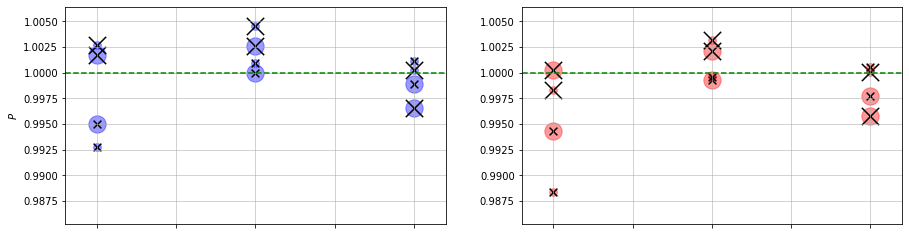

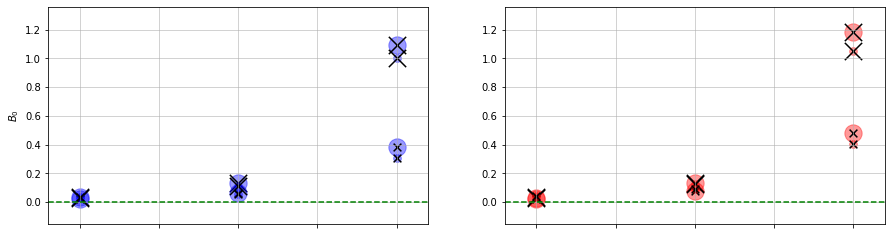

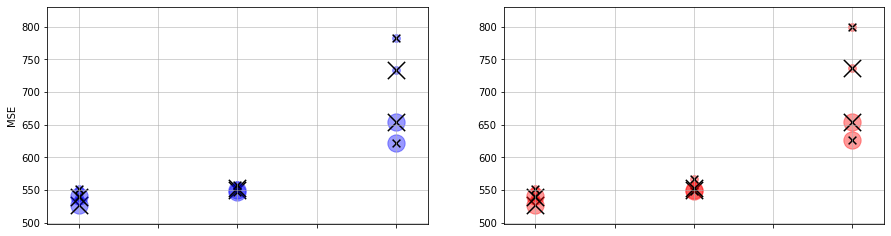

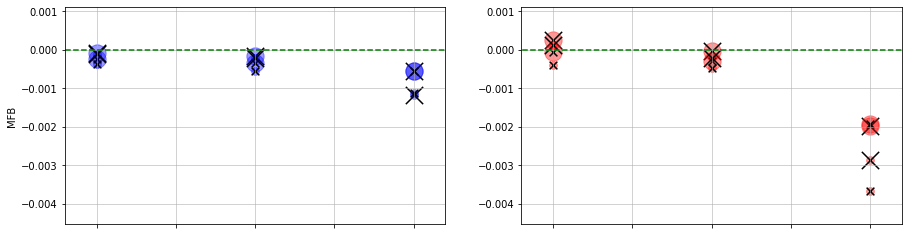

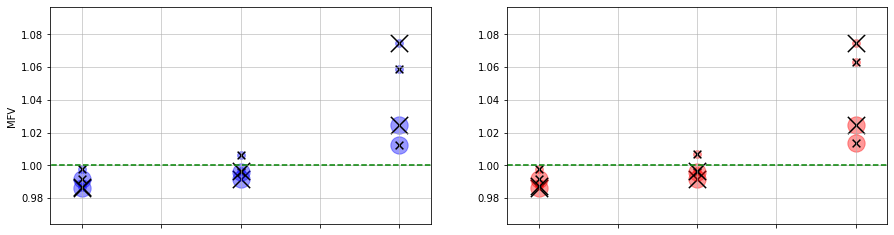

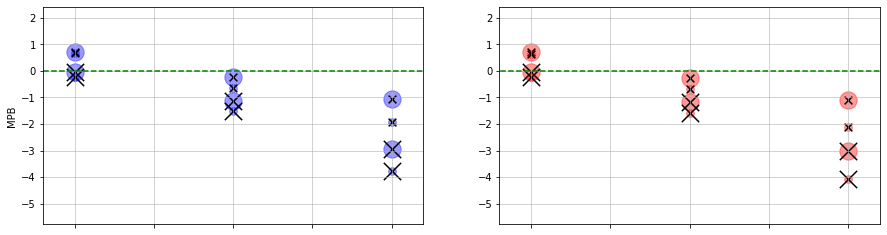

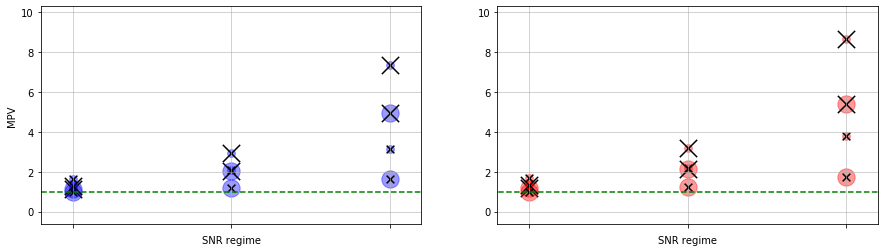

In [12]:
# mock data set to try out some visualisations
# SNR on x-axis... lowest to highest.
# for each SNR, plot a data point corresponding to the sampling regime combo
# circle == sampling regime of reference; cross == sampling regime of kernel
# size of circle/cross indicates over/undersampled reference/kernel
# i.e. big circle and small cross == oversampled reference and undersampled kernel
# try is out with photometric scale factors...
# and just compare 2xoversampled corner plots for simulated vs real data...
#'$\phi_R > 1, \phi_K > 1$'
#'$\phi_R > 1, \phi_K < 1$'
#'$\phi_R < 1, \phi_K > 1$'
#'$\phi_R < 1, \phi_K < 1$'
snr_regime = np.array([1, 2, 3]) # 1 -> 3 == increasing SNR regime
snr_regimes = np.repeat(snr_regime, 4).reshape((3*4,1))
test_metrics_pd = np.hstack((snr_regimes, metrics_pd))
test_metrics_pt = np.hstack((snr_regimes, metrics_pt))

# try this out with photometric scale factors
x_pd = test_metrics_pd[:,0]
x_pt = test_metrics_pt[:,0]

# fit quality and photometric accuracy metrics
categories = ['$P$', '$B_0$', 'MSE', 'MFB', 'MFV', 'MPB', 'MPV']

# target value
target = [1, 0, 'NaN', 0, 1, 0, 1]

# 'o' == reference frame, 'x' == kernel
markers = ['o','x']
# oversampled / undersampled markersizes
os, us = 300, 60 # ax.scatter
#os, us = 6, 6

# fontsize
fs = 16


for i,cat in enumerate(categories):
    
    y_pd = test_metrics_pd[:,i+1]
    y_pt = test_metrics_pt[:,i+1]
    
    yerr_pd_16 = pd_16[:,i]
    yerr_pt_16 = pt_16[:,i]
    yerr_pd_84 = pd_84[:,i]
    yerr_pt_84 = pt_84[:,i]
    
    ymin, ymax = np.min(y_pt), np.max(y_pt)
    pad = 1.5*mad_std(y_pt)

    j = 0
    
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    
    if i == len(categories) - 1:
        plt.setp(ax, xticks=[1, 2, 3], xlabel='SNR regime', xlim=(0.8, 3.2), ylim=(ymin-pad, ymax+pad))
    else:
        plt.setp(ax, xlim=(0.8, 3.2), ylim=(ymin-pad, ymax+pad))
        
    plt.setp(ax[0], ylabel=cat)

    if target[i] is not 'NaN':
        ax[0].hlines(target[i], 0, 4, color='green', linestyle='--')
        ax[1].hlines(target[i], 0, 4, color='green', linestyle='--')


    ax[0].grid(alpha=0.7, which='major')
    ax[1].grid(alpha=0.7, which='major')
    
    ax[0].set_xticklabels( () )
    ax[1].set_xticklabels( () )

    
    for xpd, xpt, ypd, ypt, err16pd, err16pt, err84pd, err84pt, in zip(x_pd, x_pt, y_pd, y_pt,
                                                                       yerr_pd_16, yerr_pt_16,
                                                                       yerr_pd_84, yerr_pt_84):
                
        if j == 0:
            rs, ks = os, os
        elif j == 1:
            rs, ks = os, us
        elif j == 2:
            rs, ks = us, os
        elif j == 3:
            rs, ks = us, us

        j += 1

        if j == 4:
            j = 0

        ax[0].scatter([xpd],[ypd], marker='o', s=rs, c='blue', alpha=0.4)
        ax[0].scatter([xpd],[ypd], marker='x', s=ks, c='black')
        ax[1].scatter([xpt],[ypt], marker='o', s=rs, c='red', alpha=0.4)
        ax[1].scatter([xpt],[ypt], marker='x', s=ks, c='black')
        #ax[0].errorbar(xpd, ypd, yerr=[[err16pd], [err84pd]], marker='o',
        #               markersize=rs, c='blue', alpha=0.4)
        #ax[0].errorbar(xpd, ypd, marker='x', markersize=ks, c='black')
        #ax[1].errorbar(xpt, ypt, yerr=[[err16pt], [err84pt]], marker='o',
        #               markersize=rs, c='red', alpha=0.4)
        #ax[1].errorbar(xpt, ypt, marker='x', markersize=ks, c='black')        



I think this is a pretty good way to present these results. In the left column, we have the results from the B08/pyDANDIA solutions, and the PyTorchDIA results are in right-hand column. To really make the distinction clear, I also colour the circular markers in each column; blue in the B08 column, and red in the PyTorchDIA one.

---

**Marker Key:**

The circular markers represent the sampling regime of the reference image: a big circular marker for an oversampled reference image, and a small circular marker for an undersampled reference image.

The cross markers reprsent the sampling regime of the kernel: a big marker for an oversampled kernel, and a small marker for an undersampled kernel.

Where applicable, the green dashed line represents either the true and/or best possible result.

---

**Discusion: Metric by metric**

*Photometric Scale Factor*

Of all the metrics, the biggest differences between the B08 and PyTorchDIA solutions are found here. There is no obvious overall 'best' approach - this seems to depend on some combination of the signal-to-noise and sampling regimes. The PyTorchDIA solution tends to underestimate the photometric scale factor, while the B08 solution in general overestimates it. Bramich et al. 2016 found that the B08 approach also underestimates the photometric scale factor, but recall that for the tests in this work, we background subtract the reference to break the anticorrelation between this quanity and the background term.

*MSE*

There's no large difference between the two approaches, although B08 slightly outperforms PyTorchDIA in the two higher signal-to-noise regimes when *both* the kernel and the reference frame are undersampled.

*MFB*

Both approaches show worsening MFB as the signal-to-noise increases, although B08 clearly wins in the highest signal-to-noise regime. As also reflected by the MSE, B08 does a better job than PyTorchDIA when both the kernel and reference frame are undersampled.

*MFV*

There's very little difference between the two approaches here. Depending on your view, either the B08 approach overfits slightly more than PyTorchDIA, or PyTorchDIA slightly underfits more than B08.

*MPB*

Encouragingly, the differences between the two approaches are small, with both showing the same trends with signal-to-noise regime; with increasing signal-to-noise, the MPB worsens. Within each signal-to-noise regime, the same trends with sampling regimes can also be seen. Of the two approaches, B08 is slightly better here, but the difference in the highest signal-to-noise regime are smaller than one might expcect given the MFB values for this regime, where PyTorchDIA clearly performs worse. That the MPB metrics are nonetheless similar is likely in part due to our choice to simulatenously fit for a constant scalar offset in our PSF fitting procedure, which would correct for any net over/underestimation in the background parameter of the image model.

*MPV*

And again the same trends with both signal-to-noise regime and sampling regimes can be seen by the two approaches. With increasing signal-to-noise, the MPV increases. This can be explained as reduced overfitting of the bright central stars from which this metric is computed. Again, B08 is the slightly better of the two approaches. As suggested above, including a constant offset as a free parameter in our PSF fitting procedure does a reasonable job of correcting for any over/underestimation of the background parameter in the image model, but this will be at the expense of some increased variance in the photometry. That may be responsible for what we see here.

In [1]:
def uncertainties(array):
    return np.percentile(array, [16, 84])

x = np.random.normal(0, 1, 100000)
uncertainties(x)

NameError: name 'np' is not defined

<ErrorbarContainer object of 3 artists>

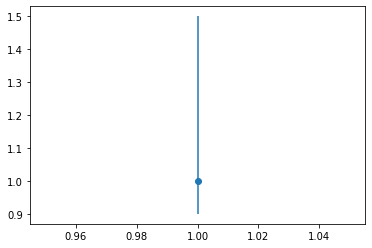

In [77]:
x = 1
y = 1
lerr = [0.1]
uerr = [0.5]

plt.errorbar(x, y, yerr=[lerr, uerr], marker='o')

In [17]:
target_size = np.array([482, 412, 312, 212])
img0_size = 4000
crop = 0.5 * (img0_size - target_size)
crop

array([1759., 1794., 1844., 1894.])